# Qwen + SAM: IA Conversacional para Segmentación Inteligente

Este notebook demuestra un enfoque **más avanzado y conversacional** para segmentación usando **Qwen2.5-VL**, un modelo multimodal que entiende tanto imágenes como texto natural.

## Configuración e Imports

Importamos **Transformers** y **qwen-vl-utils**, que nos permite usar modelos de visión y lenguaje para conversaciones sobre imágenes de forma sencilla, gratuita y en local.

In [1]:
import torch
from transformers import SamProcessor, SamModel
from transformers import AutoProcessor
from transformers import Qwen2_5_VLForConditionalGeneration
from qwen_vl_utils import process_vision_info
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import transformers
import requests
import json
import re
from io import BytesIO
import warnings
from huggingface_hub import snapshot_download
from pathlib import Path
import os, sys
warnings.filterwarnings("ignore")
transformers.logging.set_verbosity_error()

os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version: {torch.__version__}, using device: {device}")
print(f"transformers version: {transformers.__version__}")

# !pip install qwen-vl-utils

torch version: 2.6.0+cu124, using device: cuda
transformers version: 4.52.4


## Descarga de Modelos en Local

**Diferencia clave**: Solo necesitamos dos modelos para este enfoque más simplificado:

- **Qwen2.5-VL-3B**: Modelo multimodal que entiende imágenes y texto como una conversación
- **SAM**: Segmentación precisa (igual que en el notebook anterior)

**Ventaja**: Qwen reemplaza múltiples modelos (DINO, CLIP, BLIP) con uno solo más potente.


In [2]:

if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    HF_MODELS_DIR = Path("/content/drive/MyDrive/hf_models")
else:
    HF_MODELS_DIR = Path(r"G:\Mi unidad\hf_models")

HF_MODELS_DIR.mkdir(parents=True, exist_ok=True)

models = [
    "facebook/sam-vit-large",
    "Qwen/Qwen2.5-VL-3B-Instruct",
]

for repo in models:
    local_dir = HF_MODELS_DIR / repo
    snapshot_download(
        repo_id=repo,
        local_dir=str(local_dir),
        local_dir_use_symlinks=False,
        resume_download=True
)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

## Carga de Modelos

**Qwen2.5-VL** es un modelo **multimodal** que puede:
- Responder preguntas sobre imágenes
- Detectar objetos cuando se lo pedimos  
- Generar bounding boxes en formato JSON
- Mantener conversaciones sobre el contenido visual


In [3]:
# models

sam_path = HF_MODELS_DIR / "facebook/sam-vit-large"
sam_processor = SamProcessor.from_pretrained(sam_path)
sam_model = SamModel.from_pretrained(sam_path).to(device)

qwen_path = HF_MODELS_DIR / "Qwen/Qwen2.5-VL-3B-Instruct"
qwen_processor = AutoProcessor.from_pretrained(qwen_path)
qwen_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(qwen_path, torch_dtype=torch.float16, device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Carga de Imágenes de Ejemplo

Usamos las mismas imágenes que en el notebook anterior para poder comparar ambos enfoques.


In [6]:
# images
url_cars = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/cars.jpg"
image_cars = Image.open(BytesIO(requests.get(url_cars).content)).convert("RGB")

url_person_cars = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/person_cars.jpg"
image_person_cars = Image.open(BytesIO(requests.get(url_person_cars).content)).convert("RGB")

url_fruits = "https://github.com/sergiovillanueva/prompt_to_mask/raw/master/assets/fruits.jpg"
image_fruits = Image.open(BytesIO(requests.get(url_fruits).content)).convert("RGB")

## Qwen: Conversación sobre Imágenes

**Demostración**: Qwen puede responder preguntas naturales sobre imágenes.

**Proceso**:
1. Creamos un mensaje tipo chat con imagen y pregunta
2. `apply_chat_template` formatea la conversación
3. `process_vision_info` extrae la información visual
4. El modelo genera respuestas en lenguaje natural

**Ventaja**: Mucho más flexible que modelos especializados - podemos hacer **cualquier pregunta**.

**Desventaja**: Más pesado y lento que las otras alternativas.


Answer: There are five fruits in the image: a strawberry, a kiwi, a lemon, an orange, and an apple.


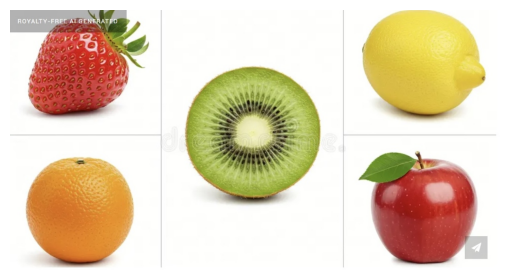

In [67]:
# qwen
# image = image_person_cars
# prompt = "What is the woman wearing?"
# prompt = "How many cars are in the image?."

image = image_fruits
prompt = "How many fruits are in the image?."

# image = Image.open("assets/carpet_ok.jpg").convert("RGB")
# prompt = "Is there any surface defect or anomaly in the image? Detect the defects or anomalies and provide bounding box coordinates if the confidence is high."

# image = Image.open("assets/carpet_nok.jpg").convert("RGB")
# prompt = "Is there any surface defect or anomaly in the image? Detect the defects or anomalies and provide bounding box coordinates if the confidence is high."

messages = [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": prompt}]}]

text = qwen_processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = qwen_processor(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to(device)

with torch.no_grad():
    generated_ids = qwen_model.generate(**inputs, max_new_tokens=256)
    
answer = qwen_processor.batch_decode([out[len(inp):] for inp, out in zip(inputs.input_ids, generated_ids)], skip_special_tokens=True)[0]
print(f"Answer: {answer}")

img_array = np.array(image)
json_match = re.search(r'```json\n(.*?)\n```', answer, re.DOTALL)
if json_match:
    data = json.loads(json_match.group(1))
    
    if data:
        for item in data:
            if 'bbox_2d' in item:
                x1, y1, x2, y2 = item['bbox_2d']
                label = item.get('label', 'object')
                
                cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 0, 255), 3)
                cv2.putText(img_array, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
plt.imshow(img_array)
plt.axis("off")
plt.show()

## Pipeline Avanzado: Qwen + SAM

**Proceso**:
1. **Qwen** entiende instrucciones complejas en lenguaje natural
2. Genera bounding boxes en **formato JSON estructurado**
3. **SAM** convierte las cajas en máscaras precisas

**Ventajas sobre Grounding DINO**:
- **Instrucciones más complejas**: "Detecta coches pero no los amarillos"
- **Respuestas estructuradas**: JSON automático con etiquetas y coordenadas
- **Mayor flexibilidad**: Un solo modelo para múltiples tareas


Answer: ```json
[
	{"bbox_2d": [31, 298, 254, 517], "label": "fruits that are from Valencia"}
]
```


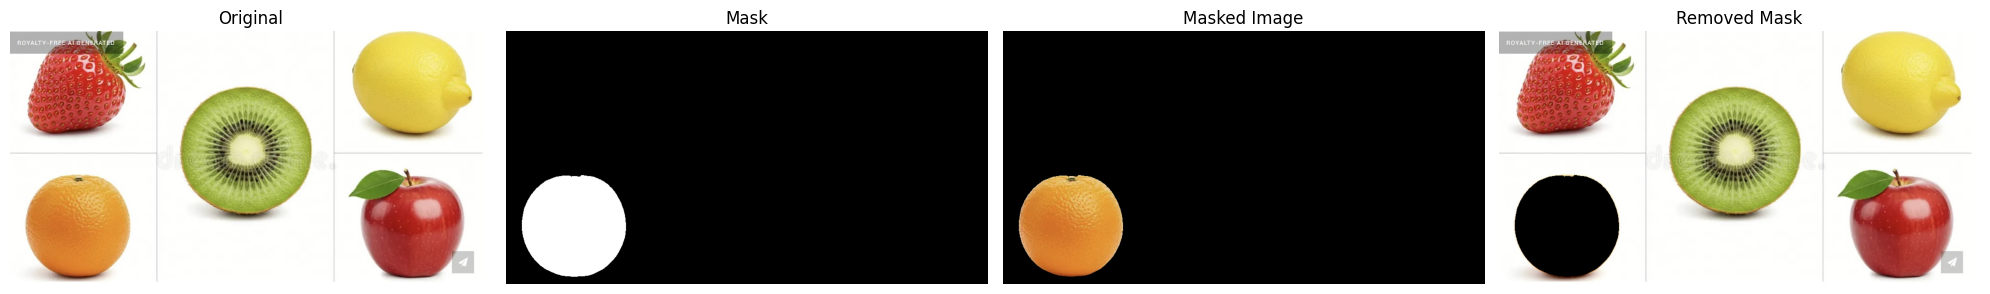

In [ ]:

# qwen + sam

# image = image_person_cars
# prompt = "Detect cars but not the yellow ones and provide bounding box coordinates."
image = image_fruits
prompt = "Detect the fruits that are from New Zealand and provide bounding box coordinates."
# prompt = "Detect the fruits that are from Valencia and provide bounding box coordinates."

w, h = image.size
boxes = []
labels = []
messages = [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": prompt}]}]

text = qwen_processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = process_vision_info(messages)
inputs = qwen_processor(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt").to(device)

with torch.no_grad():
    generated_ids = qwen_model.generate(**inputs, max_new_tokens=256)
    
answer = qwen_processor.batch_decode([out[len(inp):] for inp, out in zip(inputs.input_ids, generated_ids)], skip_special_tokens=True)[0]
print(f"Answer: {answer}")

json_match = re.search(r'```json\n(.*?)\n```', answer, re.DOTALL)
if json_match:
    data = json.loads(json_match.group(1))
    if data:
        img_array = np.array(image)
        boxes = []
        labels = []
        for item in data:
            if 'bbox_2d' in item:
                x1, y1, x2, y2 = item['bbox_2d']
                label = item.get('label', 'object')
                boxes.append([x1, y1, x2, y2])
                labels.append(label)

final_mask = np.zeros((h, w), dtype=np.float32)

if len(boxes) > 0:
        sam_inputs = sam_processor(images=image, input_boxes=[boxes], return_tensors="pt").to(device)

        with torch.no_grad():
            sam_outputs = sam_model(**sam_inputs)

        masks = sam_processor.post_process_masks(sam_outputs.pred_masks, sam_inputs["original_sizes"], sam_inputs["reshaped_input_sizes"])
        iou_scores = sam_outputs.iou_scores.cpu().numpy()
        final_mask = np.zeros((h, w), dtype=np.float32)

        for i in range(len(boxes)):
            detection_masks = masks[0][i].cpu().numpy()
            best_idx = iou_scores[0][i].argmax()
            final_mask += detection_masks[best_idx]

final_mask = np.clip(final_mask, 0, 1)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(final_mask, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")
masked_img = np.array(image) * final_mask[:,:,None]
axes[2].imshow(masked_img.astype(np.uint8))
axes[2].set_title("Masked Image")
axes[2].axis("off")
inverted_mask = 1 - final_mask
removed_img = np.array(image) * inverted_mask[:,:,None]
axes[3].imshow(removed_img.astype(np.uint8))
axes[3].set_title("Removed Mask")
axes[3].axis("off")
plt.tight_layout()
plt.show()
